<a href="https://colab.research.google.com/github/jakeoung/BayesianUnrolling/blob/master/BU3D_simple_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows a simple example of running BU3D.

The code works on both CPU and GPU mode. You can enable the CUDA in the menu: `Runtime > Change runtime type` and choose GPU in the hardware accelerator item.

In [1]:
%cd /content
!git clone https://github.com/jakeoung/BayesianUnrolling
%cd BayesianUnrolling/run
!pip install mat73

/content
fatal: destination path 'BayesianUnrolling' already exists and is not an empty directory.
/content/BayesianUnrolling/run
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import mat73
import torch
import time
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import os
os.sys.path.append("../")

from unroll.model.vanilla import Model
from gen_initial import gen_initial_multiscale, shift_h

use_cuda = True if torch.cuda.is_available() else False
print(f"use_cuda: {use_cuda}")

print("")

use_cuda: True



In [3]:
## Load the histogram data with PPP=4, SBR=1
f = 'Reindeer_4.0_1.0.mat'    
fdict = mat73.loadmat(f)
tof = torch.FloatTensor(fdict["Y"])
tof = tof[0:-1:2, 0:-1:2, :] # choose half size

H, W, T = tof.shape
to_meter = T * 0.003 # depth scale factor from [0,1] -> the unit of meter

print(f"tof shape is {tof.shape}")

tof shape is torch.Size([277, 335, 1024])


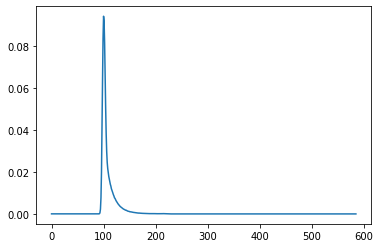

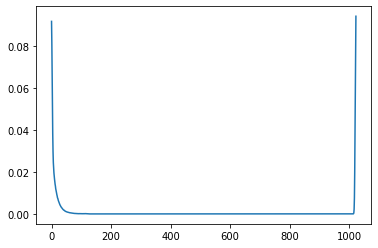

In [4]:
## Load and visualize the impulse response function
irf_ = scipy.io.loadmat("irf/irf_middlebury1024.mat")["irf"][0,:]
plt.plot(irf_); plt.show()
h1 = torch.FloatTensor(shift_h(irf_, T))

## Visualize the shifted IRF
plt.plot(h1); plt.show()

In [5]:
## Generate initial multiscale depths
L = 12
depths = gen_initial_multiscale(tof, h1, L, use_cuda=use_cuda)

4 scales completed. 8 additional scales are generated by separable 3d convolution.


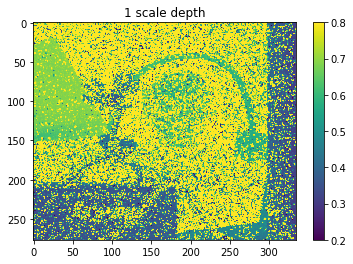

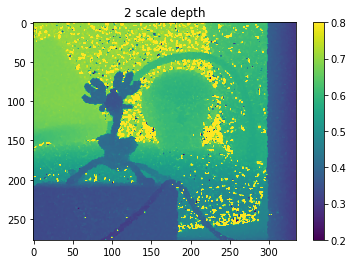

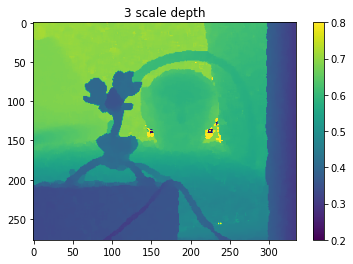

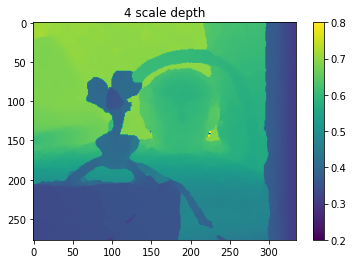

In [6]:
## Visualize the input initial multiscale depths
for i in range(4):
    plt.imshow(depths[i,:,:].cpu()*to_meter, vmin=0.2, vmax=0.8); plt.colorbar()
    plt.title(f"{i+1} scale depth"); plt.show() 

In [7]:
## Run the neural network
with torch.no_grad():
    model = Model(L)
    if use_cuda:
        model.cuda()
        model.load_state_dict(torch.load("model_baseline.pth"))
    else:
        model.load_state_dict(torch.load("model_baseline.pth", map_location=torch.device('cpu')))
    
    # to compute the uncertainty, turn on the debug option
    out = model(depths.unsqueeze(0), debug=True)

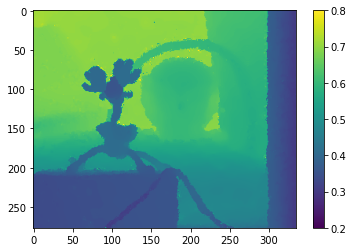

In [8]:
## Visualization of the results
depth_final = out[0][-1].cpu().numpy()

# # save the images for debugging
# depths = depths.cpu().numpy()

# if os.path.isdir("../fig/") == False:
#     os.makedirs("../fig/")

plt.imshow(depth_final[0,0,:,:]*to_meter); plt.clim(0.2, 0.8); plt.colorbar()

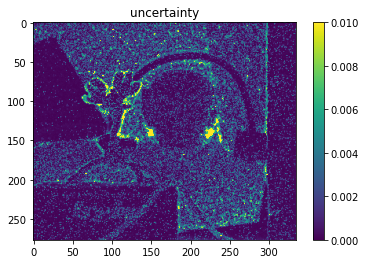

In [9]:
# Visualization of uncertainty
from compute_uncertainty import compute_uncertainty

eps = compute_uncertainty(out, to_meter=to_meter)
plt.imshow(eps, vmin=0, vmax=0.01)
plt.title("uncertainty")
plt.colorbar()
plt.show()

## (Optional) Visualization of internal layers

In [14]:
x, d, w, w2, fs, es = out
dd = out[0][-1][0,0,:,:].numpy()
rr = out[0][-1][0,0,:,:].numpy()

# crange = np.array([45, 285]) / 1024
crange = np.array([45, 285]) * 0.003
from mpl_toolkits import axes_grid1

In [36]:
def compute_vmin_vmax(eps):
    vmax = eps.max() * 0.1
    vmin = vmax * 0.01
    vmin = 0.000
    # vmax = 0.06
    vmax = 0.11
    return vmin, vmax

def add_colorbar(im, aspect=20, pad_fraction=0.5, mode=0, vmin=0, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    cbar = im.axes.figure.colorbar(im, cax=cax, **kwargs)
    if mode == 0:
        cbar.set_ticks([0.2, 0.4, 0.6, 0.8])
        cbar.ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8'])  # vertically oriented colorbar
    elif mode == 1:
        cbar.set_ticks([0.0, 0.5, 1.0])
        cbar.ax.set_yticklabels(['0', '0.5', '1.0'])  # vertically oriented colorbar
    elif mode == 2: #uncertainty
        cbar.set_ticks([0.0, 0.01, 0.02])
        cbar.ax.set_yticklabels(['0', '0.01', '0.02'])  # vertically oriented colorbar
        # cbar.set_ticks([vmin, mode])
        # cbar.ax.set_yticklabels([vmin, mode])  # vertically oriented colorbar
    else:
        pass
        
    return cbar

fs = 17

def compute_epsilon(out):
    version = 3
    w = out[2]
    w2 = out[3]
    d = out[1]

    d0 = d[0].numpy() * 1024 * 0.003
    d1 = d[1].numpy() * 1024 * 0.003
    d2 = d[2].numpy() * 1024 * 0.003
    xi = out[0][-1].numpy() * 1024 * 0.003
    ibatch=0
    ww = w2[0].numpy()[0,:,:,:]
    ww1 = w2[1].numpy()[0,:,:,:]
    ww2 = w2[2].numpy()[0,:,:,:]

    # w2 = w[2].numpy()[0,:,:,:]

    if version == 3:
        ww_norm = scipy.special.softmax(1-ww, 0)
        C1 = ww_norm * np.absolute(d0[ibatch,:,:,:] - xi[ibatch,0:1,:,:]) / 14
        ww_norm = scipy.special.softmax(1-ww1, 0)
        C2 = ww_norm * np.absolute(d1[ibatch,:,:,:] - xi[ibatch,0:1,:,:]) / 14
        ww_norm = scipy.special.softmax(1-ww2, 0)
        C3 = ww_norm * np.absolute(d2[ibatch,:,:,:] - xi[ibatch,0:1,:,:]) / 14
        epsilon = np.sum(C1 + C2 + C3, axis=0) / 3

    return epsilon

def draw_interpretability(nscale=4, ilayer=0):
    if nscale == 4:
        fig_ll = plt.figure(figsize=(16,10))
    elif nscale == 8:
        fig_ll = plt.figure(figsize=(16,20))
    else:
        fig_ll = plt.figure(figsize=(16,8*3))

    # fig_ll = plt.figure()
    nblock = 1
    ibatch = 0
    cmap_w = "viridis"

    ww = w[ilayer].numpy()
    di = d[ilayer].numpy() * 1024 * 0.003
    xi = x[ilayer].numpy() * 1024 * 0.003 

    ww2 = w2[ilayer].numpy()
    di2 = d[ilayer+1].numpy() * 1024 * 0.003
    layer=0

    for i in range(nscale):
        fig_ll.add_subplot(nscale, nblock*5, i*5*nblock+ 1 + layer*4); im=plt.imshow(di[ibatch,i,:,:], interpolation='nearest');plt.clim(crange); add_colorbar(im)
        # if i==0:
        plt.title(f"d{i+1}", fontsize=fs); plt.axis("off")
        
        
        fig_ll.add_subplot(nscale, nblock*5, i*5*nblock+ 1 + layer*4 + 1); im=plt.imshow(ww[ibatch,i,:,:], interpolation='nearest', cmap=cmap_w, vmin=0, vmax=1); add_colorbar(im, mode=1)
        # if i==0:
        plt.title(f"w{i+1}", fontsize=fs); plt.axis("off")
        
        # if layer < nblock-1:
        fig_ll.add_subplot(nscale, nblock*5, i*5*nblock+ 1 + layer*4 + 3); im=plt.imshow(ww2[ibatch,i,:,:], interpolation='nearest', cmap=cmap_w, vmin=0, vmax=1); add_colorbar(im, mode=1)
        # if i == 0:
        plt.title(f"wbar{i+1}", fontsize=fs); plt.axis("off")

        fig_ll.add_subplot(nscale, nblock*5, i*5*nblock + 1 + layer*4 + 4); im=plt.imshow(di2[ibatch,i,:,:], interpolation='nearest'); plt.clim(crange); add_colorbar(im)
        plt.title(f"d{i+2}", fontsize=fs); plt.axis("off")
        # if i==0:
        # plt.title(r"$\overline{\boldsymbol w}^{("+f"{i+1}"+r")} \boldsymbol{d}^{("+f"{i+1}"+r")} + (1-\overline{\boldsymbol w} ^{("+ f"{i+1}" +r")})\boldsymbol x$", fontsize=fs-2)

    fig_ll.add_subplot(nscale, nblock*5, 0*5*nblock+ 1 + layer*4 + 2);
    plt.imshow(xi[ibatch,0,:,:], interpolation='nearest'); plt.clim(crange);
    plt.title(f"x", fontsize=fs); plt.axis("off")

    fig_ll.show()
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.margins(0,0)
    # plt.savefig(f"/Users/jk2021/Dropbox/apps/Overleaf/unroll_tex/fig/internal{nscale}_{scene}.pdf", bbox_inches='tight', pad_inches=0.0)


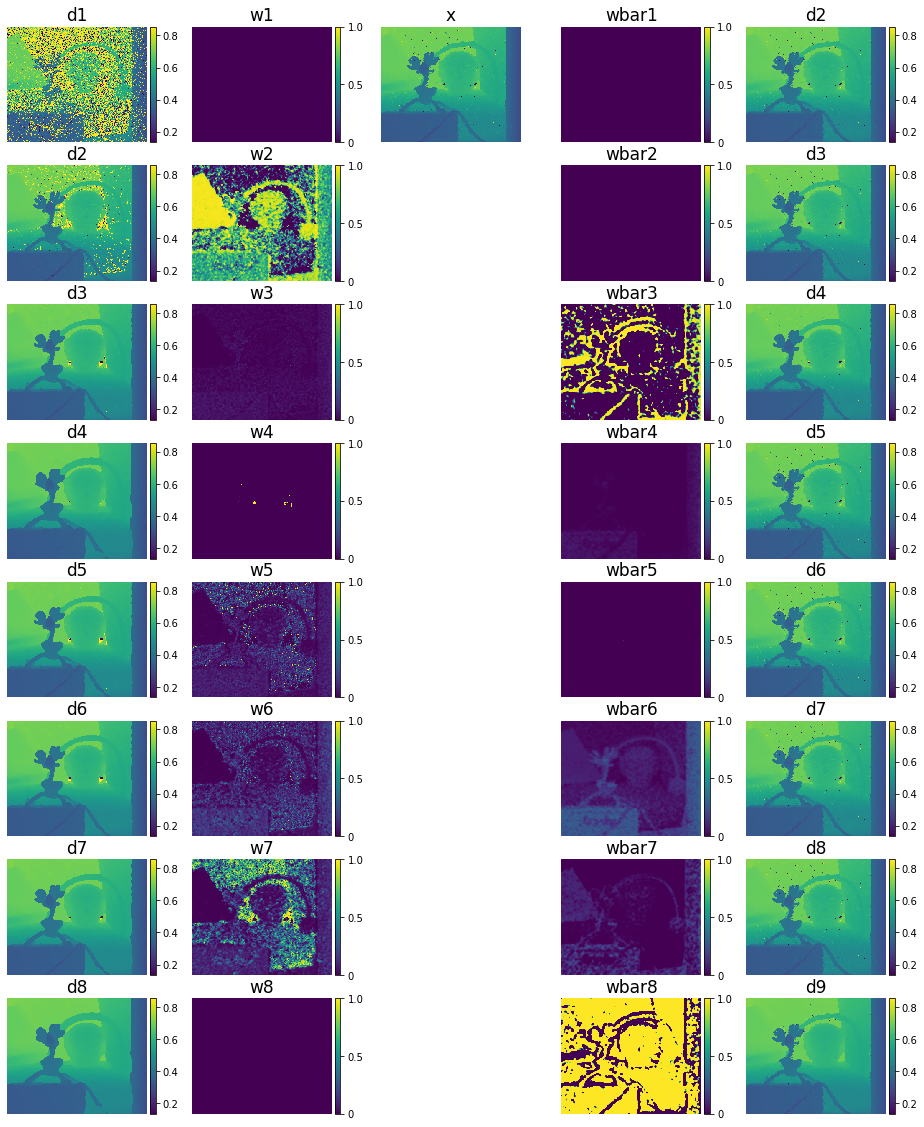

In [37]:
# Visualization of 1st stage with 8 scales 
draw_interpretability(8, 0) # See Figure 5 in the paper

In [51]:
def draw_squeezes():
    fs = 22
    # fig_ll = plt.figure(figsize=(16,5))
    fig_ll = plt.figure(figsize=(17.5,8.4))
    
    # fig_ll = plt.figure()
    nblock = 4
    ibatch = 0
    cmap_w = "viridis"
    # for layer in range(1): # 8 9 10 11
    beta = 0; alpha = 0
    d0 = d[0].numpy() * 1024 * 0.003

    for i in range(nblock):
        di = d[i].numpy() * 1024 * 0.003
        xi = x[i].numpy() * 1024 * 0.003
        ww = w[i].numpy()


        fig_ll.add_subplot(2, nblock+1, i + 1); im=plt.imshow(xi[ibatch,0,:,:], interpolation='nearest'); plt.clim(crange); plt.axis("off"); add_colorbar(im)
        plt.title(f"x{i+1}")
        # plt.title(r"$\boldsymbol x^"+f"{i+1}"+r"$", fontsize=fs)

        # ww[:] = 1.0
        Cx = np.sum(  np.absolute(di[ibatch,:,:,:] - xi[ibatch,0:1,:,:]), axis=0)
        epsilon = (Cx + beta) / (12 + alpha + 1 + 1)

        vmin, vmax = compute_vmin_vmax(epsilon)

        # vmin = epsilon.min()
        # print(vmin, vmax)
        fig_ll.add_subplot(2, nblock+1, nblock+1+1 + i ); im=plt.imshow(epsilon,  vmin=vmin, vmax=0.02, cmap="gray"); plt.axis("off"); add_colorbar(im, mode=2)
        plt.title(f"delta{i+1}")
        # plt.title(r"$\boldsymbol \delta^"+f"{i+1}"+r"$", fontsize=fs)

        # fig_ll.add_subplot(3, nblock+1, (nblock+1)*2 + 1 + i );
        # xidgt = np.absolute(xi[ibatch,0,:,:] - d_gt)
        # im=plt.imshow(xidgt, vmin=0.0, vmax=0.02, cmap="gray"); add_colorbar(im, mode=2)
        # plt.title(r"$|\boldsymbol x^"+f"{i+1}"+r"- \boldsymbol x^*|$", fontsize=fs)
        # print(np.mean(xidgt))

    epsilon2 = compute_epsilon(out)

    fig_ll.add_subplot(2, nblock+1, nblock+1 ); im=plt.imshow(epsilon2, cmap="gray", vmax=0.01);
    
    add_colorbar(im, mode=2)
    # fig_ll.add_subplot(2, nblock+1, nblock+1 ); im=plt.imshow(epsilon2, cmap="gray", vmin=vmin, vmax=vmax); add_colorbar(im, mode=vmax, vmin=vmin)
    # plt.title(r"$\boldsymbol \epsilon$", fontsize=fs)

    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.margins(0,0)
    # plt.savefig(f"/Users/jakeoung/Desktop/internal_stages_{scene}.pdf", bbox_inches='tight', pad_inches=0.10)

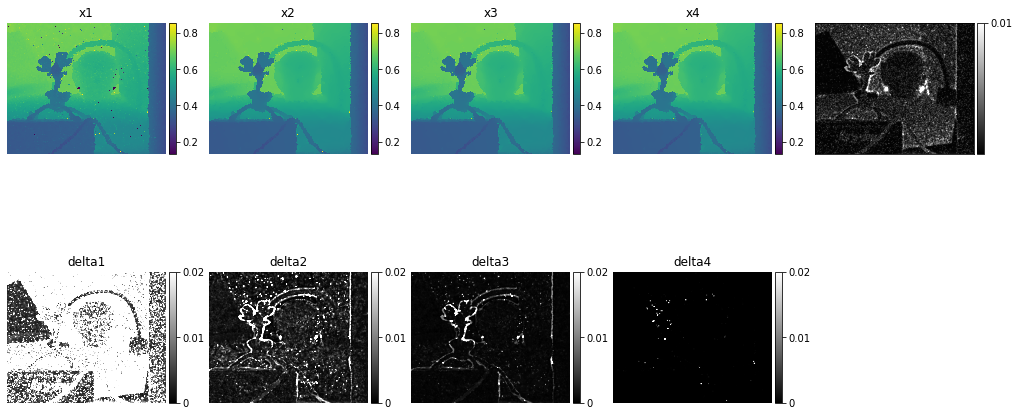

In [52]:
# Intermediate squeezed depths and their difference to multiscale depths
draw_squeezes() # See Figure 6 in the paper